# Executive Summary

# Introduction

The purpose of this study is to build a linear regression model that will predict the number of covid-19 cases for any Toronto neighborhood based on its demographic data. Predicting covid-19 cases is useful in that an understanding of which socioeconomic factors that influence the growth of disease in a community will help with our understanding of the virus. This knowledge will enable resources to be better targeted in the future to help prevent transmission during this, or any future pandemic.

### Load Libraries

In [654]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np
%matplotlib inline
import warnings
from scipy import stats
warnings.filterwarnings('ignore')

## Data

A population Census is held across Canada every 5 years. It collects data about age and sex, families and households, language, immigration and internal migration, racial diversity, Aboriginal peoples, housing, education, income, and labor. 
The City of Toronto Neighborhood Profiles use this Census data to provide a portrait of the demographic, social and economic characteristics of the people and households in each City of Toronto neighborhood.



The data is made available through Toronto's Open Data portal (https://open.toronto.ca/).

Two datasets from this site were used for this study. One that shows the number of covid cases by Toronto neighborhood (https://open.toronto.ca/dataset/covid-19-cases-in-toronto/) and the other contains demographic features of each of these neighborhoods (https://open.toronto.ca/dataset/neighbourhood-profiles/). There are over 2,300 features show for each neighborhood including:

### Load Files

In [655]:
covid_to = pd.read_csv('data/CityofToronto_COVID-19_NeighbourhoodData.csv')

In [656]:
neigh = pd.read_csv("data/neighbourhood-profiles-2016-csv_ADJ.csv")

### Data Cleaning

The demographic data is a huge dataset containing over 2300 rows, each one representing a different demographic feature. In order to create one usable dataset the following tasks were performed:

1. The dataset was transposed so that the columns, which are the Toronto neighborhoods become row and each feature becomes a column.
2. Every column is given a unique identifying name.
3. A dataframe was created to capture the column descriptions which are quite lengthy.
4. Null rows were dropped - these were summary rows which did not relate to each neighborhood.
5. All the numeric columns were converted to floats - there were no categorical columns.
6. The two dataframes (demographic data and covid case data) were merged on the neighborhood id column to create one dataframe.

In [657]:
# The Neighbourhood file has Neighbourhoods as columns so we must 
# transpose it.
neighTO = neigh.transpose()

There are over 2300 columns. Let's keep track of the names meanings of these columns so we can 
later use this information to interpret the results. In the meantime we will refer to the columns by
their numeric names.

In [658]:
# Let's the column names to strings
neighTO.columns = ["Col_" + str(x) for x in neighTO.columns]

In [659]:
colNames = neighTO.iloc[0:5,:].transpose()

In [660]:
# Now we have a dataframe of all the column names
colNames.head(5).iloc[:,0:5]

,_id,Category,Topic,Special,Characteristic
Col_0,1,Neighbourhood Information,Neighbourhood Information,NaN,Neighbourhood Number
Col_1,1030,Income,Income of households in 2015,X,Average after-tax income of households in 20...
Col_2,2040,Income,Income sources,NaN,Workers' compensation benefits: Aggregat...
Col_3,2349,Income,Income sources,NaN,Goods and services tax (GST) credit and ...
Col_4,2352,Income,Income sources,NaN,Government transfers not included elsewh...


In [661]:
# Let's remove all the descriptive rows
neighTO = neighTO.iloc[5:,:]

In [662]:
# We can remove the city of Toronto
neighTO = neighTO[neighTO.index != 'City of Toronto']

In [663]:
# Let's ensure the neighborhoodID in both files is an int so we can
# join the files
neighTO['Col_0'] = neighTO['Col_0'].astype(int)

In [664]:
# We drop the null row and convert ID to int
covid_to.dropna(inplace=True)
covid_to['Neighbourhood ID'] = covid_to['Neighbourhood ID'].astype(int)

In [665]:
# Let's convert the demographic data to floats - select only string columns
for x in neighTO.select_dtypes(include='object').columns:
    if x != 'Col_0':
        # Remove % symbol if present
        neighTO[x] = neighTO[x].replace({'%':''}, regex = True)
        neighTO[x] = neighTO[x].astype(float)

In [666]:
# We see they are all floats except for the int column
neighTO.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140 entries, Agincourt North to Yorkdale-Glen Park
Columns: 2306 entries, Col_0 to Col_2305
dtypes: float64(2305), int64(1)
memory usage: 2.5+ MB


In [667]:
# Now we can see that all our columns are numeric
neighTO.describe().iloc[:,1:5]

,Col_1,Col_2,Col_3,Col_4
count,1.400000e+02,140.000000,140.000000,140.000000
mean,3.512761e+05,1097.607143,340.564286,404.300000
std,2.309379e+05,1389.841530,25.668952,65.398469
min,1.022590e+05,0.000000,283.000000,273.000000
25%,1.953375e+05,0.000000,323.000000,353.500000
50%,2.915495e+05,658.500000,340.000000,399.500000
75%,4.305408e+05,1691.500000,355.250000,448.000000
max,1.413132e+06,7510.000000,409.000000,623.000000


We need to join the datasets so we have one dataset with all the features and target.

In [668]:
# Rename the column so they match in both files
neighTO.rename(columns={'Col_0': "Neighbourhood ID"}, inplace=True)

In [669]:
# Join the files on Neighbourhood ID
NeighCases = pd.merge(neighTO, covid_to, how='left', on=['Neighbourhood ID'])

In [670]:
# Let's write this to excel to back it up.
NeighCases.to_csv("data/NeigCases.csv")

In [701]:
# Let's add a column for the case rate - case count/neighborhood population
NeighCases['CovidRate'] = NeighCases['Case Count']/NeighCases['Col_1']

In [712]:
NeighCases

,Neighbourhood ID,Col_1,Col_2,Col_3,Col_4,Col_5,Col_6,Col_7,Col_8,Col_9,...,Col_2300,Col_2301,Col_2302,Col_2303,Col_2304,Col_2305,Neighbourhood Name,"Rate per 100,000 people",Case Count,CovidRate
0,129,427037.0,234.0,356.0,514.0,932.0,1344.0,1385.0,1577.0,1733.0,...,99.0108,22.0177,25.8647,37.9899,47.8824,85.8723,Agincourt North,838.113558,244,0.000571
1,128,278390.0,367.0,341.0,452.0,914.0,1453.0,985.0,1411.0,2294.0,...,98.7919,24.0350,27.0657,34.8108,51.1007,85.8694,Agincourt South-Malvern West,723.997138,172,0.000618
2,20,168602.0,2067.0,327.0,342.0,746.0,1585.0,1546.0,1246.0,8613.0,...,99.7594,32.1055,26.0494,26.9205,58.1964,85.1585,Alderwood,945.744151,114,0.000676
3,95,792507.0,554.0,300.0,336.0,733.0,1127.0,584.0,1005.0,4617.0,...,93.8217,30.5805,32.8409,22.6856,63.4377,86.1724,Annex,861.560637,263,0.000332
4,42,493486.0,316.0,326.0,399.0,825.0,1285.0,1478.0,1310.0,2039.0,...,97.4725,28.3806,23.7227,32.3705,52.1394,84.4376,Banbury-Don Mills,498.284889,138,0.000280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,94,239484.0,1163.0,327.0,356.0,735.0,1414.0,1198.0,1200.0,7269.0,...,92.3409,27.8765,28.1901,23.3117,56.0318,79.3435,Wychwood,968.708621,139,0.000580
136,100,222648.0,0.0,308.0,302.0,737.0,1303.0,772.0,1217.0,0.0,...,99.8985,34.0188,29.3222,21.2406,63.3409,84.6238,Yonge-Eglinton,423.119235,50,0.000225
137,97,541217.0,0.0,299.0,318.0,729.0,1135.0,357.0,828.0,0.0,...,98.1801,34.8819,28.7356,24.9840,63.5776,88.5217,Yonge-St.Clair,462.962963,58,0.000107
138,27,302358.0,3501.0,347.0,417.0,783.0,2002.0,2133.0,1727.0,7529.0,...,99.9166,24.0822,28.9204,32.3089,52.9845,85.2571,York University Heights,2866.669083,791,0.002616


## Data Exploration

There's a huge difference in the rate of covid-19 cases in each Toronto neighborhood. 

The top 5 neighborhoods **dramatically higher case rates** than the bottom five neighborhoods (Figure 1).

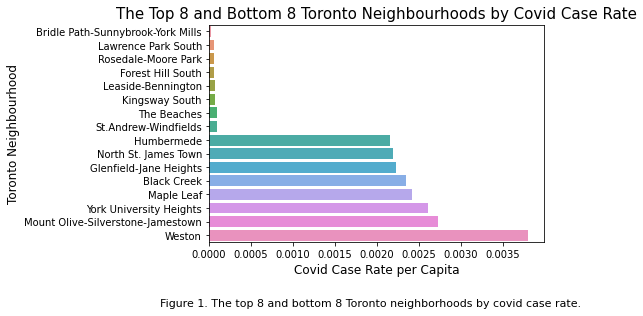

In [711]:
sns.reset_orig()
df = NeighCases[['Neighbourhood Name', "CovidRate"]].sort_values("CovidRate")
df.columns = ['Neighbourhood', 'CovidRate']

ax = sns.barplot(data=df.head(8).append(df.tail(8)), y='Neighbourhood',x='CovidRate',orient='h')
txt="Figure 1. The top 8 and bottom 8 Toronto neighborhoods by covid case rate."
# plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=14)
plt.figtext(0.5, -0.1, txt, wrap=True, horizontalalignment='center', fontsize=11)

plt.title('The Top 8 and Bottom 8 Toronto Neighbourhoods by Covid Case Rate',fontsize= 15)
plt.xlabel("Covid Case Rate per Capita", fontsize=12)
plt.ylabel("Toronto Neighbourhood", fontsize=12);

The rate in the neighborhood of Weston has a covid case rate of almost 136 times that of the Bridle Path Sunnybrook-York Mills neighborhood.

In [707]:
df.head(1).append(df.tail(1))

,Neighbourhood,CovidRate
16,Bridle Path-Sunnybrook-York Mills,0.000028
126,Weston,0.003800


Various media reports have shown that certain demographic factors can influence covid rates. Reports have shown that the virus has disproportionately affected communities based on the following factors:


* Racial Profile<br>
* Density<br>
* Employment<br>
* Income<br>

In [677]:
NeighCases

,Neighbourhood ID,Col_1,Col_2,Col_3,Col_4,Col_5,Col_6,Col_7,Col_8,Col_9,...,Col_2299,Col_2300,Col_2301,Col_2302,Col_2303,Col_2304,Col_2305,Neighbourhood Name,"Rate per 100,000 people",Case Count
0,129,427037.0,234.0,356.0,514.0,932.0,1344.0,1385.0,1577.0,1733.0,...,90.5609,99.0108,22.0177,25.8647,37.9899,47.8824,85.8723,Agincourt North,838.113558,244
1,128,278390.0,367.0,341.0,452.0,914.0,1453.0,985.0,1411.0,2294.0,...,84.8382,98.7919,24.0350,27.0657,34.8108,51.1007,85.8694,Agincourt South-Malvern West,723.997138,172
2,20,168602.0,2067.0,327.0,342.0,746.0,1585.0,1546.0,1246.0,8613.0,...,20.6570,99.7594,32.1055,26.0494,26.9205,58.1964,85.1585,Alderwood,945.744151,114
3,95,792507.0,554.0,300.0,336.0,733.0,1127.0,584.0,1005.0,4617.0,...,23.8158,93.8217,30.5805,32.8409,22.6856,63.4377,86.1724,Annex,861.560637,263
4,42,493486.0,316.0,326.0,399.0,825.0,1285.0,1478.0,1310.0,2039.0,...,45.8567,97.4725,28.3806,23.7227,32.3705,52.1394,84.4376,Banbury-Don Mills,498.284889,138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,94,239484.0,1163.0,327.0,356.0,735.0,1414.0,1198.0,1200.0,7269.0,...,25.3328,92.3409,27.8765,28.1901,23.3117,56.0318,79.3435,Wychwood,968.708621,139
136,100,222648.0,0.0,308.0,302.0,737.0,1303.0,772.0,1217.0,0.0,...,26.6988,99.8985,34.0188,29.3222,21.2406,63.3409,84.6238,Yonge-Eglinton,423.119235,50
137,97,541217.0,0.0,299.0,318.0,729.0,1135.0,357.0,828.0,0.0,...,20.3943,98.1801,34.8819,28.7356,24.9840,63.5776,88.5217,Yonge-St.Clair,462.962963,58
138,27,302358.0,3501.0,347.0,417.0,783.0,2002.0,2133.0,1727.0,7529.0,...,69.3473,99.9166,24.0822,28.9204,32.3089,52.9845,85.2571,York University Heights,2866.669083,791


<AxesSubplot:xlabel='Col_2294', ylabel='CovidRate'>

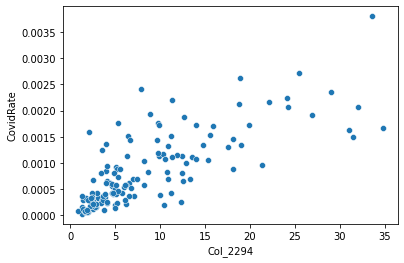

In [714]:
# Black
df = NeighCases[['Col_2294','CovidRate']]

sns.scatterplot(data=df, x='Col_2294',y='CovidRate')

<AxesSubplot:xlabel='Col_2299', ylabel='Rate per 100,000 people'>

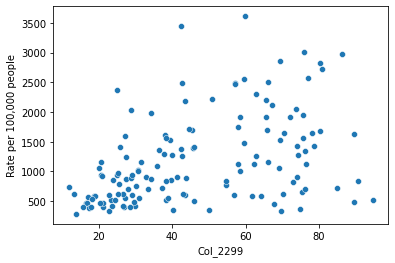

In [683]:
df = NeighCases[['Col_2299','Rate per 100,000 people']]

sns.scatterplot(data=df, x='Col_2299',y='Rate per 100,000 people')

In [713]:
# Income
colNames[colNames['Special'] == 'X']

,_id,Category,Topic,Special,Characteristic
Col_1,1030,Income,Income of households in 2015,X,Average after-tax income of households in 20...
Col_551,75,"Families, households and marital status",Household and dwelling characteristics,X,Average household size
Col_639,1153,Immigration and citizenship,Immigrant status and period of immigration,X,Immigrants
Col_1764,1969,Journey to work,Main mode of commuting,X,Public transit
Col_2286,1346,Visible minority,Visible minority population,X,Japanese
Col_2287,1345,Visible minority,Visible minority population,X,Korean
Col_2288,1344,Visible minority,Visible minority population,X,West Asian
Col_2289,1148,Visible minority,Visible minority population,X,Latin American
Col_2290,1347,Visible minority,Visible minority population,X,Visible minority; n.i.e.
Col_2291,1343,Visible minority,Visible minority population,X,Southeast Asian


<AxesSubplot:xlabel='Col_1', ylabel='Rate per 100,000 people'>

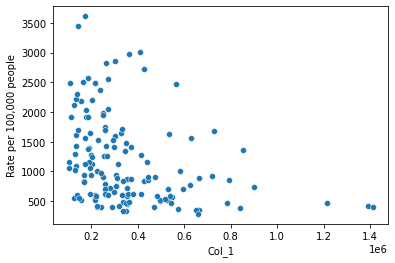

In [24]:
# Average after tax houshold income vs covid rate
df = NeighCases[['Col_1','Rate per 100,000 people']]

sns.scatterplot(data=df, x='Col_1',y='Rate per 100,000 people')

In [25]:
df

,Col_1,"Rate per 100,000 people"
0,427037.0,838.113558
1,278390.0,723.997138
2,168602.0,945.744151
3,792507.0,861.560637
4,493486.0,498.284889
...,...,...
135,239484.0,968.708621
136,222648.0,423.119235
137,541217.0,462.962963
138,302358.0,2866.669083


<AxesSubplot:xlabel='Col_1764', ylabel='Rate per 100,000 people'>

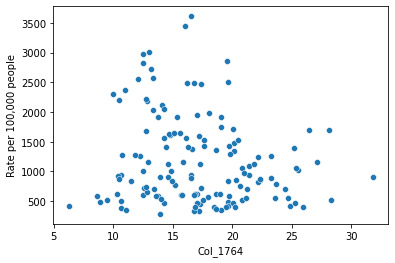

In [26]:
# rate of transit use
df = NeighCases[['Col_1764','Rate per 100,000 people']]

sns.scatterplot(data=df, x='Col_1764',y='Rate per 100,000 people')

<AxesSubplot:xlabel='Col_551', ylabel='Rate per 100,000 people'>

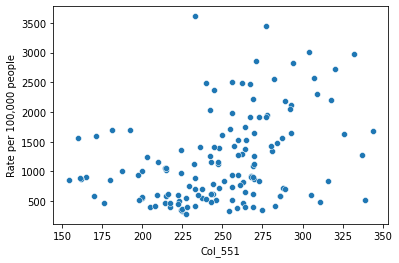

In [27]:
# Average Houseghold size
df = NeighCases[['Col_551','Rate per 100,000 people']]

sns.scatterplot(data=df, x='Col_551',y='Rate per 100,000 people')

<AxesSubplot:xlabel='Col_639', ylabel='Rate per 100,000 people'>

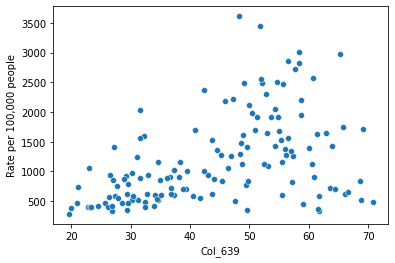

In [28]:
# Immigrant
df = NeighCases[['Col_639','Rate per 100,000 people']]
sns.scatterplot(data=df, x='Col_639',y='Rate per 100,000 people')


## Feature Selection

In [87]:
# Let's look at all the features and how they compare to 
# the target
cor = NeighCases.corr()
threshold = 0.6
a=abs(cor['Rate per 100,000 people'])
result=pd.DataFrame(a[a>0.6])
feat_cor = result.sort_values('Rate per 100,000 people', ascending=False).head(100)

In [88]:
# Let's remove the Case Count column and examine these variables
feat_cor.drop('Case Count', inplace=True)
feat_cor.drop('Rate per 100,000 people', inplace=True)

In [89]:
feat_cor.reset_index(level=0, inplace=True)

In [91]:
#colNames.reset_index(level=0, inplace=True)

In [92]:
dfCol = colNames[['index','Category', 'Characteristic']]

In [93]:
feat_corName = pd.merge(feat_cor, dfCol, how='left', on=['index'])

In [134]:
feat_corName.sort_values(by='Rate per 100,000 people', ascending=False)

,index,"Rate per 100,000 people",Category,Characteristic
0,Col_2294,0.744462,Visible minority,Black
1,Col_690,0.741155,Immigration and citizenship,Jamaica
2,Col_695,0.737332,Immigration and citizenship,Americas
3,Col_463,0.731440,Ethnic origin,Jamaican
4,Col_2109,0.727272,Language,Niger-Congo languages
...,...,...,...,...
93,Col_1080,0.614768,Language,Creole languages; n.i.e.
94,Col_779,0.614017,Income,"$100,000 and over"
95,Col_1135,0.613796,Language,French
96,Col_841,0.613480,Income,Basic Canada Child Tax Benefit (CCTB): P...


In [149]:
feat_corName

,index,"Rate per 100,000 people",Category,Characteristic
0,Col_2294,0.744462,Visible minority,Black
1,Col_690,0.741155,Immigration and citizenship,Jamaica
2,Col_695,0.737332,Immigration and citizenship,Americas
3,Col_463,0.731440,Ethnic origin,Jamaican
4,Col_2109,0.727272,Language,Niger-Congo languages
...,...,...,...,...
93,Col_1080,0.614768,Language,Creole languages; n.i.e.
94,Col_779,0.614017,Income,"$100,000 and over"
95,Col_1135,0.613796,Language,French
96,Col_841,0.613480,Income,Basic Canada Child Tax Benefit (CCTB): P...


In [191]:
# Return top from each category
groupMax = feat_corName.groupby(["Category"])
groupMax.max('Rate per 100,000 people')

,"Rate per 100,000 people"
Category,
Education,0.677432
Ethnic origin,0.731440
"Families, households and marital status",0.690976
Housing,0.630043
Immigration and citizenship,0.741155
Income,0.684938
Journey to work,0.666780
Labour,0.726118
Language,0.727272


In [197]:
# *****
# Let's find the rows with the highest value for each category
idx = feat_corName.groupby(['Category'])['Rate per 100,000 people'].transform(max) == \
feat_corName['Rate per 100,000 people']
feat_corName[idx]

,index,"Rate per 100,000 people",Category,Characteristic
0,Col_2294,0.744462,Visible minority,Black
1,Col_690,0.741155,Immigration and citizenship,Jamaica
3,Col_463,0.731440,Ethnic origin,Jamaican
4,Col_2109,0.727272,Language,Niger-Congo languages
5,Col_2179,0.726118,Labour,9 Occupations in manufacturing and utilities
13,Col_480,0.690976,"Families, households and marital status",3 or more children
15,Col_713,0.684938,Income,In the third decile
19,Col_543,0.677432,Education,Bachelor's degree
26,Col_2281,0.666780,Journey to work,Between 12 p.m. and 4:59 a.m.
72,Col_601,0.630043,Housing,2 household maintainers


In [210]:
# ****
# Let's create a dataframe using only these values and let's make the
# columns more readable.
NeighCovid = NeighCases[feat_corName[idx]['index']]
NeighCovid['Rate'] = NeighCases['Rate per 100,000 people']

In [213]:
NeighCovid.columns = ['Black%', 'Jamaica%', 'Jamaican', 'CongoLang', 'ManufactJob', 'MoreThan2Kids',\
                      'ThirdDecIncome', 'BachelorDegree', 'WorkNights', 'BothMaintHouse', 'Rate']

In [214]:
NeighCovid



,Black%,Jamaica%,Jamaican,CongoLang,ManufactJob,MoreThan2Kids,ThirdDecIncome,BachelorDegree,WorkNights,BothMaintHouse,Rate
0,4.6028,1.7174,2.6792,0.0859,4.6371,0.4294,12.7091,15.0448,6.0969,11.8504,838.113558
1,6.5033,1.6627,2.7150,0.2105,4.2724,0.6314,12.3753,17.7211,6.9453,12.1438,723.997138
2,2.4888,0.3733,1.0370,0.0830,2.9036,0.3318,8.3375,13.7714,7.5908,16.9653,945.744151
3,3.0630,0.5733,1.3267,0.1310,0.3931,0.1474,5.6018,29.9253,5.7164,15.7734,861.560637
4,3.5024,0.7944,1.4804,0.2708,0.5958,0.1986,7.4021,23.4699,4.1885,14.4430,498.284889
...,...,...,...,...,...,...,...,...,...,...,...
135,6.0283,1.4635,2.9270,0.1394,1.1151,0.4530,8.1887,19.3045,5.9238,14.2170,968.708621
136,2.4964,0.2539,0.6347,0.0423,0.2539,0.2962,5.3313,30.6761,4.7389,15.5285,423.119235
137,1.8758,0.3991,0.7982,0.0399,0.1596,0.0798,5.7072,29.6935,4.5099,15.1660,462.962963
138,18.8635,4.0409,7.4113,1.7396,5.7805,1.1054,13.1374,14.1703,9.6220,11.1079,2866.669083


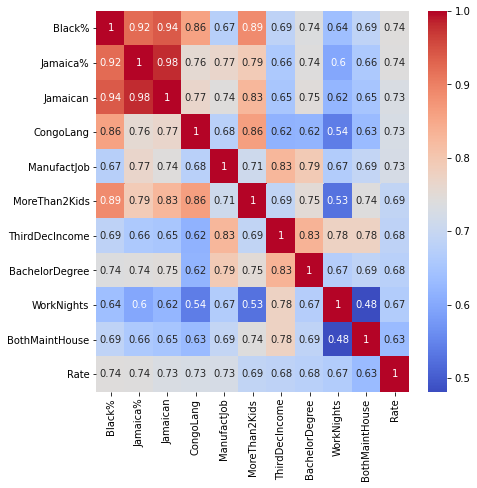

In [217]:
# Correlation of variables
plt.figure(figsize=(7,7))
sns.heatmap(abs(NeighCovid.corr()), annot=True, cmap="coolwarm");

It makes sense than language, ethnic origin, language and visible minority categories of data
are highly correlated. Let's remove the _Jamaica%_, _Jamaican_, and _CongoLang_ predictors.

In [221]:
#****
NeighCovid.drop(['Jamaica%', 'Jamaican', 'CongoLang'], axis=1, inplace=True)

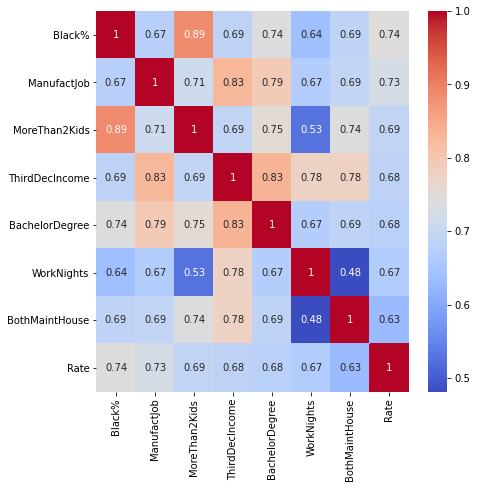

In [223]:
#****
plt.figure(figsize=(7,7))
sns.heatmap(abs(NeighCovid.corr()), annot=True, cmap="coolwarm");

In the interest of simplicity we can reduce features further. Black and Morethan2Kids is highly correlated, as well as ManufactJob and ThirdDecIncome so we will reduce the features that are least correlated with Rate.

In [224]:
NeighCovid.drop(['MoreThan2Kids', 'ThirdDecIncome'], axis=1, inplace=True)

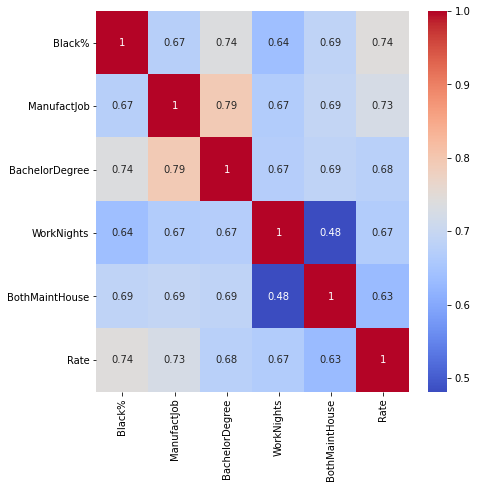

In [225]:
plt.figure(figsize=(7,7))
sns.heatmap(abs(NeighCovid.corr()), annot=True, cmap="coolwarm");

In [226]:
NeighCovid

,Black%,ManufactJob,BachelorDegree,WorkNights,BothMaintHouse,Rate
0,4.6028,4.6371,15.0448,6.0969,11.8504,838.113558
1,6.5033,4.2724,17.7211,6.9453,12.1438,723.997138
2,2.4888,2.9036,13.7714,7.5908,16.9653,945.744151
3,3.0630,0.3931,29.9253,5.7164,15.7734,861.560637
4,3.5024,0.5958,23.4699,4.1885,14.4430,498.284889
...,...,...,...,...,...,...
135,6.0283,1.1151,19.3045,5.9238,14.2170,968.708621
136,2.4964,0.2539,30.6761,4.7389,15.5285,423.119235
137,1.8758,0.1596,29.6935,4.5099,15.1660,462.962963
138,18.8635,5.7805,14.1703,9.6220,11.1079,2866.669083


<AxesSubplot:xlabel='Rate', ylabel='Density'>

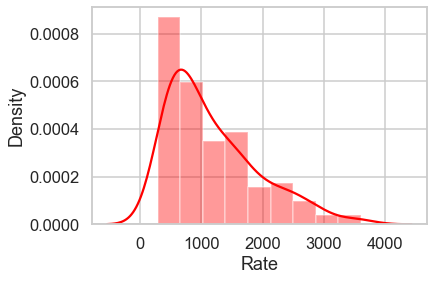

In [231]:
sns.distplot(NeighCovid["Rate"], color = "red")

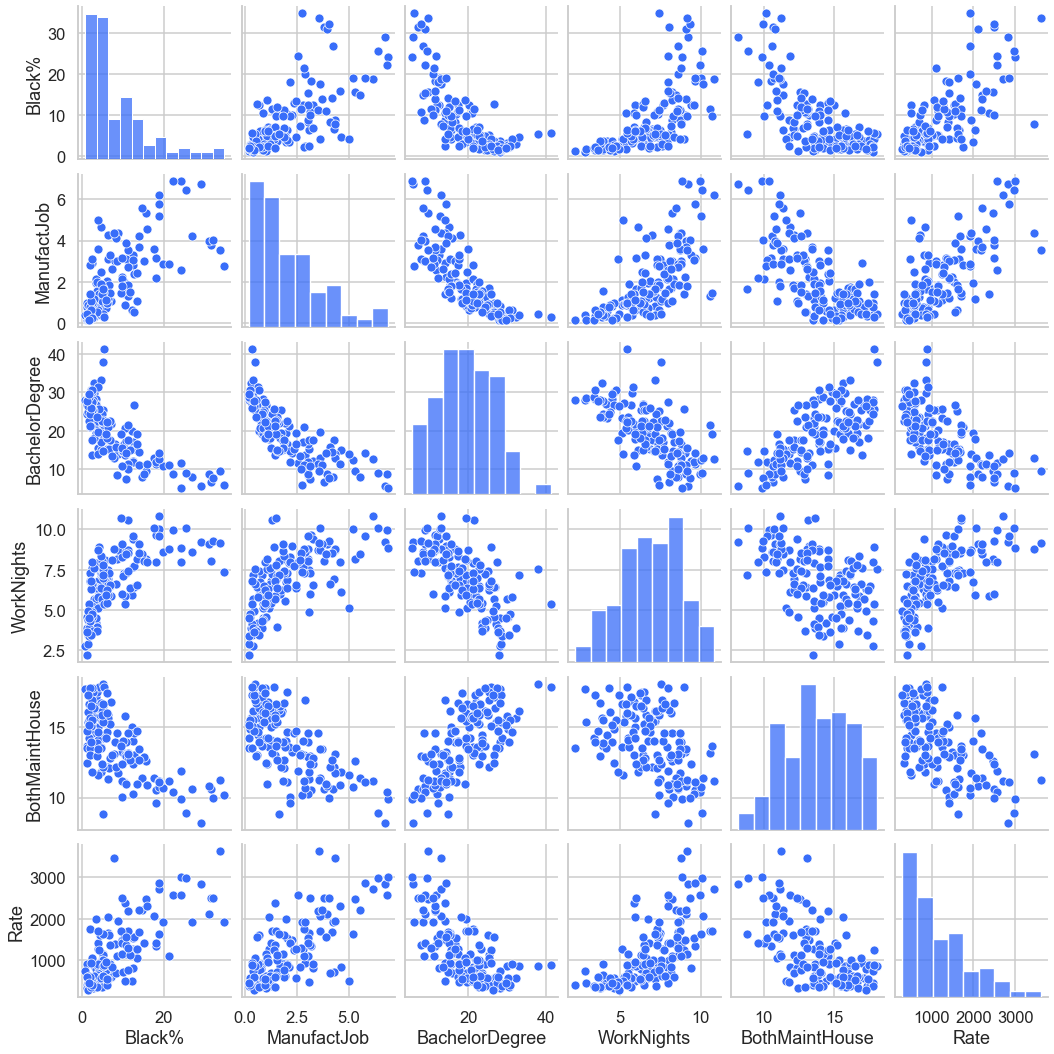

In [510]:
#sns.set(style='whitegrid', context='talk', palette='rainbow')

sns.pairplot(NeighCovid)

In [587]:
NeighCovid.corr()

,Black%,ManufactJob,BachelorDegree,WorkNights,BothMaintHouse,Rate
Black%,1.000000,0.674802,-0.738437,0.638839,-0.686939,0.744462
ManufactJob,0.674802,1.000000,-0.793575,0.666698,-0.692824,0.726118
BachelorDegree,-0.738437,-0.793575,1.000000,-0.670800,0.686422,-0.677432
WorkNights,0.638839,0.666698,-0.670800,1.000000,-0.481592,0.666780
BothMaintHouse,-0.686939,-0.692824,0.686422,-0.481592,1.000000,-0.630043
Rate,0.744462,0.726118,-0.677432,0.666780,-0.630043,1.000000


In [380]:
X = NeighCases[["Col_2294", "Col_690", "Col_695", "Col_463", "Col_2109", "Col_2179"]]

In [393]:
X = NeighCases[['Col_2240', 'Col_535', 'Col_2078', 'Col_2032', 'Col_2030', 'Col_530','Col_529']]

In [685]:
# **** ALEXEI ****

# F-score: 171.57t for feature Col_2294 
# F-score: 168.20t for feature Col_690 
# F-score: 164.41t for feature Col_695 
# F-score: 158.78t for feature Col_463 
# F-score: 154.95t for feature Col_2109 
# F-score: 153.91t for feature Col_2179 

X = NeighCovid[['Black%', 'BachelorDegree', 'WorkNights','BothMaintHouse','ManufactJob']]
# X = df_out[['Black%']]
# X = df_out.drop('Rate', axis=1)
# X = NeighCases[predColumns]
y = NeighCases['Case Count']/NeighCases['Col_1']

In [686]:
NeighCovid

,Black%,ManufactJob,BachelorDegree,WorkNights,BothMaintHouse,Rate
0,4.6028,4.6371,15.0448,6.0969,11.8504,838.113558
1,6.5033,4.2724,17.7211,6.9453,12.1438,723.997138
2,2.4888,2.9036,13.7714,7.5908,16.9653,945.744151
3,3.0630,0.3931,29.9253,5.7164,15.7734,861.560637
4,3.5024,0.5958,23.4699,4.1885,14.4430,498.284889
...,...,...,...,...,...,...
135,6.0283,1.1151,19.3045,5.9238,14.2170,968.708621
136,2.4964,0.2539,30.6761,4.7389,15.5285,423.119235
137,1.8758,0.1596,29.6935,4.5099,15.1660,462.962963
138,18.8635,5.7805,14.1703,9.6220,11.1079,2866.669083


In [687]:
X

,Black%,BachelorDegree,WorkNights,BothMaintHouse,ManufactJob
0,4.6028,15.0448,6.0969,11.8504,4.6371
1,6.5033,17.7211,6.9453,12.1438,4.2724
2,2.4888,13.7714,7.5908,16.9653,2.9036
3,3.0630,29.9253,5.7164,15.7734,0.3931
4,3.5024,23.4699,4.1885,14.4430,0.5958
...,...,...,...,...,...
135,6.0283,19.3045,5.9238,14.2170,1.1151
136,2.4964,30.6761,4.7389,15.5285,0.2539
137,1.8758,29.6935,4.5099,15.1660,0.1596
138,18.8635,14.1703,9.6220,11.1079,5.7805


In [688]:
# from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)

In [689]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 11)

In [690]:
from sklearn.linear_model import LinearRegression

#Create the model :
regressor = LinearRegression()

#Train the model :
regressor.fit(X_train, y_train)

LinearRegression()

In [691]:
L = regressor.coef_
L

array([ 0.00023178,  0.00014543,  0.00029234, -0.00018039,  0.00015337])

In [692]:
coeff_X = pd.DataFrame(regressor.coef_, index = NeighCovid.columns[:-1], columns=['Coefficient'])
coeff_X

,Coefficient
Black%,0.000232
ManufactJob,0.000145
BachelorDegree,0.000292
WorkNights,-0.000180
BothMaintHouse,0.000153


In [693]:
regressor.intercept_

0.0008714737908482595

In [694]:
print("Rate = {:.2f} + {:.2f}*Black% + {:.2f}*ManufactJob + {:.2f}*BachelorDegree + {:.2f}*WorkNights + {:.2f}*BothMaintHouse ".
      format(regressor.intercept_,L[0], L[1], L[2] ,L[3], L[4]))

Rate = 0.00 + 0.00*Black% + 0.00*ManufactJob + 0.00*BachelorDegree + -0.00*WorkNights + 0.00*BothMaintHouse 


In [695]:
y_pred = regressor.predict(X_test)

In [696]:
df_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_results.head(10)

,Actual,Predicted
97,0.000422,0.000373
116,0.000093,0.000084
46,0.000370,0.000566
100,0.001114,0.001354
51,0.000814,0.001125
29,0.000245,0.000135
69,0.000058,-0.000078
94,0.000184,0.000614
9,0.000296,0.000181
61,0.001142,0.001642


<AxesSubplot:xlabel='Actual', ylabel='Predicted'>

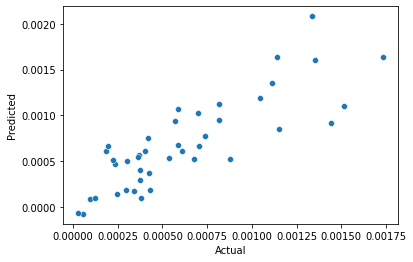

In [697]:
sns.scatterplot(data=df_results, x = 'Actual', y = 'Predicted')

In [698]:
from sklearn.metrics import mean_squared_error , r2_score

mse = mean_squared_error(y_test, y_pred)

# Root Mean Squared Error:
root_mse = np.sqrt(mse)

#R_squared : 
R_squared = r2_score(y_test, y_pred)

print("Intercept:              ", regressor.intercept_)
print("Root Mean Square Error: ", root_mse)
print("R^2 Value in %:              ", R_squared*100)

Intercept:               0.0008714737908482595
Root Mean Square Error:  0.0002796292711821966
R^2 Value in %:               57.33403020586787


In [484]:
NeighCovid

,Black%,ManufactJob,BachelorDegree,WorkNights,BothMaintHouse,Rate
0,4.6028,4.6371,15.0448,6.0969,11.8504,838.113558
1,6.5033,4.2724,17.7211,6.9453,12.1438,723.997138
2,2.4888,2.9036,13.7714,7.5908,16.9653,945.744151
3,3.0630,0.3931,29.9253,5.7164,15.7734,861.560637
4,3.5024,0.5958,23.4699,4.1885,14.4430,498.284889
...,...,...,...,...,...,...
135,6.0283,1.1151,19.3045,5.9238,14.2170,968.708621
136,2.4964,0.2539,30.6761,4.7389,15.5285,423.119235
137,1.8758,0.1596,29.6935,4.5099,15.1660,462.962963
138,18.8635,5.7805,14.1703,9.6220,11.1079,2866.669083


<AxesSubplot:>

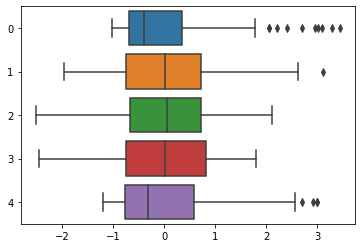

In [699]:
sns.boxplot(data=X, orient="h")

<AxesSubplot:>

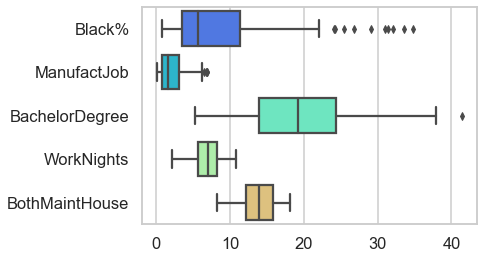

In [604]:
# Outliers
sns.boxplot(data=NeighCovid.drop('Rate',axis=1), orient="h")

<AxesSubplot:>

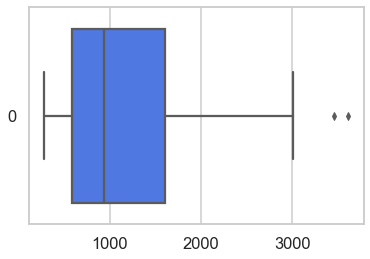

In [605]:
sns.boxplot(data=NeighCovid['Rate'], orient="h")

In [606]:
NeighCovid['Black%'].sort_values()

64      0.8629
16      1.2411
85      1.2735
130     1.2990
9       1.3557
        ...   
38     30.9856
10     31.4733
80     32.0753
126    33.5983
107    34.7551
Name: Black%, Length: 140, dtype: float64

In [607]:
# Remove outliers
from scipy import stats
# IQR
Q1 = NeighCovid.quantile(0.25)
Q3 = NeighCovid.quantile(0.75)
IQR = Q3 - Q1
print(IQR)
# This gives us the IQR for every column

Black%               7.828625
ManufactJob          2.179850
BachelorDegree      10.449550
WorkNights           2.569075
BothMaintHouse       3.631775
Rate              1015.872298
dtype: float64


In [608]:
# Q3 + (1.5 * IQR)

df_out = NeighCovid[~((NeighCovid < (Q1 - 1.5 * IQR)) |(NeighCovid > (Q3 + 1.5 * IQR))).any(axis=1)]

In [501]:
df_out.describe()

,Black%,ManufactJob,BachelorDegree,WorkNights,BothMaintHouse,Rate
count,127.000000,127.000000,127.000000,127.000000,127.000000,127.000000
mean,6.934332,1.852815,20.062574,6.705386,14.185567,1043.790879
std,4.960270,1.388270,6.344255,1.834959,2.138642,592.197847
min,0.862900,0.159600,7.551100,2.212400,8.835500,282.839523
25%,3.231350,0.811200,15.032400,5.484950,12.667750,578.007065
50%,5.117500,1.464600,19.772400,6.741000,14.095000,890.992622
75%,10.380100,2.816850,24.998150,8.043800,15.872900,1410.060445
max,21.301800,6.199000,37.957000,10.821900,18.088500,2866.669083


<AxesSubplot:xlabel='Black%', ylabel='Rate'>

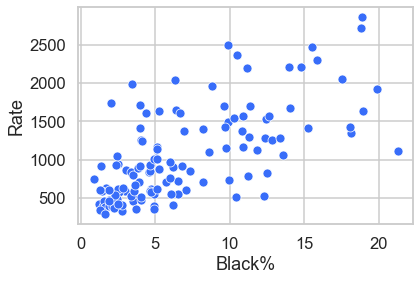

In [505]:
sns.scatterplot(data=df_out, x='Black%', y='Rate')

<AxesSubplot:xlabel='Black%', ylabel='Rate'>

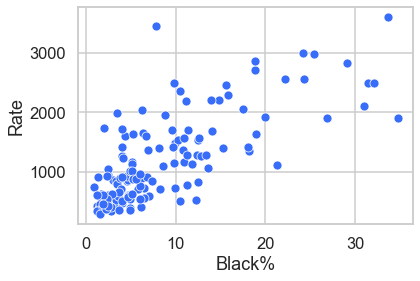

In [506]:
sns.scatterplot(data=NeighCovid, x='Black%', y='Rate')

In [373]:
# We will scale the predictors
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
# X is all the feature columns
X = NeighCases.drop(['Neighbourhood ID','Rate per 100,000 people','Case Count', \
                 'Neighbourhood Name'], axis=1)
X = pd.DataFrame(sc.fit_transform(X))
y = NeighCases['Rate per 100,000 people']
#Standardize the data
X_new = SelectKBest(f_regression, k=5).fit(X, y)

In [885]:
df.columns = [['Col_1','Col_2','Col_3','Col_4','Col_5']]

In [374]:
X_new

SelectKBest(k=5, score_func=<function f_regression at 0x7fd1c6719160>)

In [882]:
var_col_name = [x for x in X.columns]

for c in var_col_name:
    if df[['Col_1']].equals(X[[c]]):
        print(c)

    

In [881]:
X[['Col_4']]

,Col_4
0,514.0
1,452.0
2,342.0
3,336.0
4,399.0
5,426.0
6,346.0
7,418.0
8,411.0
9,362.0


In [878]:
df2 = df[["Col_1"]]
df4 = df[['Col_1']]

In [879]:
df2.equals(df4)

True

In [873]:
df['Col_1']

TypeError: only integer scalar arrays can be converted to a scalar index

In [869]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   (Col_1,)  140 non-null    float64
 1   (Col_2,)  140 non-null    float64
 2   (Col_3,)  140 non-null    float64
 3   (Col_4,)  140 non-null    float64
 4   (Col_5,)  140 non-null    float64
dtypes: float64(5)
memory usage: 5.6 KB


In [870]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140 entries, 0 to 139
Columns: 2305 entries, Col_1 to Col_2305
dtypes: float64(2305)
memory usage: 2.5 MB


KeyError: -3

In [48]:
featNames

['Col_2294',
 'Col_690',
 'Col_695',
 'Col_463',
 'Col_2109',
 'Col_2179',
 'Col_662',
 'Col_422',
 'Col_469',
 'Col_2258',
 'Col_411',
 'Col_1097',
 'Col_2266',
 'Col_480',
 'Col_1095',
 'Col_713',
 'Col_2240',
 'Col_2208',
 'Col_884',
 'Col_543',
 'Col_542',
 'Col_535',
 'Col_538',
 'Col_544',
 'Col_686',
 'Col_773',
 'Col_2281',
 'Col_2078',
 'Col_531',
 'Col_452',
 'Col_1327',
 'Col_2279',
 'Col_2032',
 'Col_488',
 'Col_781',
 'Col_489',
 'Col_443',
 'Col_771',
 'Col_487',
 'Col_2180',
 'Col_114',
 'Col_548',
 'Col_1741',
 'Col_106',
 'Col_483',
 'Col_533',
 'Col_536',
 'Col_461',
 'Col_1077',
 'Col_2030',
 'Col_530',
 'Col_875',
 'Col_2280',
 'Col_712',
 'Col_878',
 'Col_2272',
 'Col_801',
 'Col_171',
 'Col_2289',
 'Col_789',
 'Col_459',
 'Col_2177',
 'Col_837',
 'Col_850',
 'Col_880',
 'Col_836',
 'Col_29',
 'Col_1740',
 'Col_547',
 'Col_274',
 'Col_1864',
 'Col_1742',
 'Col_601',
 'Col_529',
 'Col_1861',
 'Col_1888',
 'Col_528',
 'Col_651',
 'Col_1031',
 'Col_703',
 'Col_109',
 

In [83]:
X = NeighCases[featNames]
y = NeighCases['Rate per 100,000 people']

from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFECV
from sklearn.svm import SVR
estimator = SVR(kernel="linear")
selector = RFECV(estimator, step=1, cv=5)
selector = selector.fit(X, y)
selector.support_

print(X.columns[selector.support_])

Index(['Col_2294', 'Col_690', 'Col_695', 'Col_463', 'Col_2109', 'Col_2179',
       'Col_662', 'Col_422', 'Col_469', 'Col_2258', 'Col_411', 'Col_1097',
       'Col_2266', 'Col_480', 'Col_1095', 'Col_713', 'Col_2240', 'Col_2208',
       'Col_884', 'Col_543', 'Col_542', 'Col_535', 'Col_538', 'Col_544',
       'Col_686', 'Col_773', 'Col_2281', 'Col_2078', 'Col_531', 'Col_452',
       'Col_1327', 'Col_2279', 'Col_2032', 'Col_488', 'Col_781', 'Col_489',
       'Col_443', 'Col_771', 'Col_487', 'Col_2180', 'Col_114', 'Col_548',
       'Col_1741', 'Col_106', 'Col_483', 'Col_533', 'Col_536', 'Col_461',
       'Col_1077', 'Col_2030', 'Col_530', 'Col_875', 'Col_2280', 'Col_712',
       'Col_878', 'Col_2272', 'Col_801', 'Col_171', 'Col_2289', 'Col_789',
       'Col_459', 'Col_2177', 'Col_837', 'Col_850', 'Col_880', 'Col_836',
       'Col_29', 'Col_1740', 'Col_547', 'Col_274', 'Col_1864', 'Col_1742',
       'Col_601', 'Col_529', 'Col_1861', 'Col_1888', 'Col_528', 'Col_651',
       'Col_1031', 'Col_7

In [86]:
X.shape

(1000, 25)

In [98]:
df_new = NeighCases[featNames]

In [100]:
NeighCases['Rate per 100,000 people']

0       838.113558
1       723.997138
2       945.744151
3       861.560637
4       498.284889
          ...     
135     968.708621
136     423.119235
137     462.962963
138    2866.669083
139    2492.569576
Name: Rate per 100,000 people, Length: 140, dtype: float64

In [101]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

# Build a classification task using 3 informative features
# X, y = make_classification(n_samples=1000, n_features=25, n_informative=3,
#                            n_redundant=2, n_repeated=0, n_classes=8,
#                            n_clusters_per_class=1, random_state=0)

X = df_new
y = NeighCases['Rate per 100,000 people']

# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2),
              scoring='accuracy')
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

ValueError: Supported target types are: ('binary', 'multiclass'). Got 'continuous' instead.

In [920]:
from sklearn.feature_selection import RFECV

In [52]:
X.columns

Index(['Col_2294', 'Col_690', 'Col_695', 'Col_463', 'Col_2109', 'Col_2179',
       'Col_662', 'Col_422', 'Col_469', 'Col_2258', 'Col_411', 'Col_1097',
       'Col_2266', 'Col_480', 'Col_1095', 'Col_713', 'Col_2240', 'Col_2208',
       'Col_884', 'Col_543', 'Col_542', 'Col_535', 'Col_538', 'Col_544',
       'Col_686', 'Col_773', 'Col_2281', 'Col_2078', 'Col_531', 'Col_452',
       'Col_1327', 'Col_2279', 'Col_2032', 'Col_488', 'Col_781', 'Col_489',
       'Col_443', 'Col_771', 'Col_487', 'Col_2180', 'Col_114', 'Col_548',
       'Col_1741', 'Col_106', 'Col_483', 'Col_533', 'Col_536', 'Col_461',
       'Col_1077', 'Col_2030', 'Col_530', 'Col_875', 'Col_2280', 'Col_712',
       'Col_878', 'Col_2272', 'Col_801', 'Col_171', 'Col_2289', 'Col_789',
       'Col_459', 'Col_2177', 'Col_837', 'Col_850', 'Col_880', 'Col_836',
       'Col_29', 'Col_1740', 'Col_547', 'Col_274', 'Col_1864', 'Col_1742',
       'Col_601', 'Col_529', 'Col_1861', 'Col_1888', 'Col_528', 'Col_651',
       'Col_1031', 'Col_7

In [53]:
# Feature Selection using 
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_regression
Selector_f = SelectPercentile(f_regression, percentile=25)
Selector_f.fit(X,y)
for n,s in zip(X.columns,Selector_f.scores_):
    print ("F-score: %3.2ft for feature %s " % (s,n))

F-score: 171.57t for feature Col_2294 
F-score: 168.20t for feature Col_690 
F-score: 164.41t for feature Col_695 
F-score: 158.78t for feature Col_463 
F-score: 154.95t for feature Col_2109 
F-score: 153.91t for feature Col_2179 
F-score: 153.33t for feature Col_662 
F-score: 143.38t for feature Col_422 
F-score: 142.29t for feature Col_469 
F-score: 139.12t for feature Col_2258 
F-score: 138.14t for feature Col_411 
F-score: 135.88t for feature Col_1097 
F-score: 135.55t for feature Col_2266 
F-score: 126.09t for feature Col_480 
F-score: 124.28t for feature Col_1095 
F-score: 121.96t for feature Col_713 
F-score: 121.22t for feature Col_2240 
F-score: 117.29t for feature Col_2208 
F-score: 117.06t for feature Col_884 
F-score: 117.04t for feature Col_543 
F-score: 116.47t for feature Col_542 
F-score: 114.03t for feature Col_535 
F-score: 113.90t for feature Col_538 
F-score: 113.82t for feature Col_544 
F-score: 113.73t for feature Col_686 
F-score: 111.04t for feature Col_773 
F-s

In [54]:
X

,Col_2294,Col_690,Col_695,Col_463,Col_2109,Col_2179,Col_662,Col_422,Col_469,Col_2258,...,Col_763,Col_805,Col_840,Col_1446,Col_1151,Col_1080,Col_779,Col_1135,Col_841,Col_1739
0,4.6028,1.7174,5.6160,2.6792,0.0859,4.6371,0.0515,0.1889,4.9634,0.0343,...,8.6044,13.5506,9.2227,88.6889,4.2421,0.0687,1.7346,4.4654,9.6005,26.0193
1,6.5033,1.6627,5.9561,2.7150,0.2105,4.2724,0.0421,0.4630,5.8720,0.1052,...,8.5448,12.9436,9.7024,89.3421,4.4618,0.0842,2.1678,4.3145,9.1973,22.2040
2,2.4888,0.3733,3.7332,1.0370,0.0830,2.9036,0.0000,0.1244,2.9036,0.0000,...,15.8868,13.1906,7.7568,93.0397,7.3834,0.0000,6.0561,7.7568,7.4249,21.6940
3,3.0630,0.5733,5.3397,1.3267,0.1310,0.3931,0.0655,0.3767,2.4569,0.0328,...,19.3114,9.6803,16.1010,93.9363,19.7045,0.0328,12.1700,19.4261,2.5552,8.2389
4,3.5024,0.7944,4.8204,1.4804,0.2708,0.5958,0.1083,0.3791,2.9428,0.0542,...,16.6637,9.8393,11.7530,90.4676,10.4532,0.0722,9.2797,10.4712,5.6147,10.3809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,6.0283,1.4635,6.6904,2.9270,0.1394,1.1151,0.0697,0.5575,5.1572,0.0000,...,13.2065,12.1960,12.7187,87.9155,13.8686,0.1394,7.1782,13.6595,5.7495,14.0428
136,2.4964,0.2539,4.9082,0.6347,0.0423,0.2539,0.0846,0.5501,2.3695,0.0000,...,19.8020,8.9701,14.3437,95.6673,17.3056,0.0000,14.0476,17.3902,4.1889,6.9392
137,1.8758,0.3991,5.5476,0.7982,0.0399,0.1596,0.0000,0.0798,2.3547,0.0000,...,22.8688,8.9799,15.4853,96.3841,18.4786,0.1596,14.2880,18.8777,2.4345,8.3014
138,18.8635,4.0409,13.2099,7.4113,1.7396,5.7805,1.5221,4.1858,12.1226,0.5980,...,7.0851,14.6052,7.0308,87.7215,4.3852,0.4168,1.1960,4.7838,9.9663,22.1977


,Col_2294
Col_2179,False
Col_2208,False
Col_2240,False
Col_411,False
Col_535,False
Col_538,False
Col_542,False
Col_543,False
Col_713,False
Col_884,False


In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler

In [104]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=0)
X_train.shape, X_test.shape

((98, 98), (42, 98))

In [105]:
scaler = StandardScaler()
scaler.fit(X_train.fillna(0))

StandardScaler()

In [115]:
sel_ = SelectFromModel(LogisticRegression(C=1, penalty='l2'))
#sel_.fit(scaler.transform(X_train, y_train))

In [116]:
sel_

SelectFromModel(estimator=LogisticRegression(C=1))

In [117]:
sel_.fit(X_train, y_train)

ValueError: Unknown label type: 'continuous'

In [120]:
# *********
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
model = LinearRegression()
#Initializing RFE model
rfe = RFE(model, 7)
#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  
#Fitting the data to model
model.fit(X_rfe,y)
print(rfe.support_)
print(rfe.ranking_)


[False False False False False False False False False False False False
 False False False False  True False False False False  True False False
 False False False  True False False False False  True False False False
 False False False False False False False False False False False False
 False  True  True False False False False False False False False False
 False False False False False False False False False False False False
 False  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[61 59 65 14 47 78 57 80 15 64 32 24  5  6  2 13  1 73 63 31 90  1 35 85
 58 52 18  1 44 91 39 72  1  7 26 36 76 25 19 62 50 29 60 79  8 16 17 88
 28  1  1 70 53 71 89 86 75 81 45 74 46 56 11 77 66 12 92 37 43 10 34 27
 67  1 33 30 84 48 41 20 69 23 54 42 49 38  3  9 55  4 83 51 21 68 82 22
 87 40]


In [125]:
X.columns[rfe.support_]

Index(['Col_2240', 'Col_535', 'Col_2078', 'Col_2032', 'Col_2030', 'Col_530',
       'Col_529'],
      dtype='object')

In [133]:
colNames[colNames['index'] == 'Col_529']

,level_0,index,_id,Category,Topic,Special,Characteristic
529,529,Col_529,1707,Education,"Highest certificate, diploma or degree",NaN,Certificate of Apprenticeship or Certifi...
